## 2021-04-06 - Use 3D reddening to estimate distance to saturation ##

Authors: Will Clarkson (UM-D) & Alessandro Mazzi (INAF)

**Requirements:** For this to run, you need the following:
   * The 3D extinction map itself. Our current prototype is here: http://www-personal.umd.umich.edu/~wiclarks/rubin/merged_ebv3d_nside64.fits.gz
   * The .py routines from this repository should be accessible to this notebook. (On my datalab account, I have them symlinked from my local copy of this github repository).
        * Thanks to the Datalab update, the SaturationStacker should now be a standard stacker in sims_maf. If it is not, this notebook imports the SaturationStacker from file saturationStacker.py, which is included in this repository.
        * On Sciserver, the SaturationStacker doesn't seem to be available, but it does import without difficulty from the local saturationStacker.py
   * sims_maf needs to be working on your system.
   

**Aim:** Use a 3D extinction map and a saturation map to estimate the distance at which a particular class of objects would saturate for a given opsim. We have constructed a 3D reddening map at NSIDE=64 using Lallement et al. 2019 for nearby distances, Bovy et al.'s composite reddening map for intermediate distances (which includes Marshall et al. (2006) for the inner Plane and Green et al. (2019) for most of the rest of the sky). L+19 is scaled to match Bovy et al. at L19's maximum distance, with the Planck (2013) 2D reddening map used as the far-distance reddening for sight-lines (mostly far from the Plane) in which Bovy et al. predicts zero reddening. (References to be added.)

**2021-04-06 WATCHOUT - this is still a prototype, pieced together from various works in progress and set up to run on Datalab in Will's test area.** A few things to bear in mind:
  * The reddening map is loaded from a local copy, generated using compareExtinctions.loopSightlines(). At NSIDE=64 this map is 92 M compressed, so I'm a bit wary of attaching it to the github repository. 
  * ~This probably won't work on Sciserver yet (paths are hard-coded for Datalab).~ This DOES now work on Sciserver as well as Datalab (no need to change paths manually).
  * Several pieces should probably be refactored into .py (like all the saturation cells) for convenience when calling from a notebook.
  * For the moment, this notebook calculates the saturation levels (in all filters) for a couple of example opsims. Then near the bottom, two routes to computing the distance to saturation are shown. The first uses the saturation levels calculated here, the second reads them in from a run that was performed earlier.
  * Some improvements would still be useful to the methods that estimate distance at saturation.
  * At present, values are NOT interpolated over distance (or delta-magnitude) but instead the nearest value is found. For most purposes this should be OK (within the Lallement et al. 2019 volume the extinction map is sampled at intervals of 10 pc, outside this volume the distance resolution is closer to 40pc (varies by sight-line to ensure the same number of bins along each sight-line).
  * (For the saturation metric:) We should decide whether we really want the median saturation level, or instead some percentile (e.g. the 80th percentile seeing? Or the 20th?)

### Preliminaries ###

In [1]:
# where are we?
import os
print(os.getcwd())

/home/idies/workspace/Storage/wiclarks/persistent/trySaturated


In [2]:
%matplotlib inline

In [3]:
# some standard pieces
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os, glob # for checking existence of db

### Saturation stacker ###

In [4]:
import lsst.sims.maf.stackers as stackers

In [5]:
## is the saturation stacker available yet?
try:
    SaturationStacker = stackers.SaturationStacker
except:
    SaturationStacker = None

# If the saturation stacker is not available on this system (or has not
# been defined in a previous run through this notebook), import it from 
# local .py file
if SaturationStacker is None:
    print("Importing saturation stacker from local .py file")
    from saturationStacker import SaturationStacker

Importing saturation stacker from local .py file


In [6]:
SaturationStacker

saturationStacker.SaturationStacker

In [7]:
## if the saturation stacker has not yet been defined, import the local .py version of the SaturationStacker. 
## (This should allow rerunning of the same notebook without problems if SaturationStacker 
## was defined in a previous pass.)
#if SaturationStacker is None:
#    from saturationStacker import SaturationStacker


In [8]:
# 2021-04-06 LJ suggestion:
stackers.ColInfo().getDataSource(colName='saturation_mag')

saturationStacker.SaturationStacker

In [9]:
## 2021-02-28 This is the saturation stacker written and bugfixed by Peter Yoachim. Pasted here until
## the updated stacker is available on Datalab and on Sciserver. If rerunning the entire notebook, 
## you will probably need to restart and clear outputs beforehand.
#class SaturationStacker(stackers.BaseStacker):
#    """Calculate the saturation limit of a point source. Assumes Guassian PSF.
    
#    Parameters
#    ----------
#    pixscale : float, opt (0.2)
#        Arcsec per pixel
#    gain : float, opt (2.3)
#        electrons per adu
#    saturation_e : float, opt (150e3)
#        The saturation level in electrons
#    zeropoints : dict-like, opt (None)
#        The zeropoints for the telescope. Keys should be str with filter names, values in mags.
#        If None, will use Rubin-like zeropoints.
#    km : dict-like, opt (None)
#        Atmospheric extinction values.  Keys should be str with filter names. If None, will use Rubin-like zeropoints.
#    """
#    colsAdded = ['saturation_mag']

#    def __init__(self, seeingCol='seeingFwhmEff', skybrightnessCol='skyBrightness',
#                 exptimeCol='visitExposureTime', nexpCol='numExposures',
#                 filterCol='filter', airmassCol='airmass',
#                 saturation_e=150e3, zeropoints=None, km=None, pixscale=0.2, gain=1.0):
#        self.units = ['mag']
#        self.colsReq = [seeingCol, skybrightnessCol, exptimeCol, nexpCol, filterCol, airmassCol]
#        self.seeingCol = seeingCol
#        self.skybrightnessCol = skybrightnessCol
#        self.exptimeCol = exptimeCol
#        self.nexpCol = nexpCol
#        self.filterCol = filterCol
#        self.airmassCol = airmassCol
#        self.saturation_adu = saturation_e/gain
#        self.pixscale = 0.2
#        names = ['u', 'g', 'r', 'i', 'z', 'y']
#        types = [float]*6
#        if zeropoints is None:
#            # Note these zeropoints are calculating the number of *electrons* per second (thus gain=1)
#            # https://github.com/lsst-pst/syseng_throughputs/blob/master/notebooks/Syseng%20Throughputs%20Repo%20Demo.ipynb
#            self.zeropoints = np.array([27.03, 28.38, 28.15, 27.86, 27.46, 26.68]).view(list(zip(names, types)))
#            self.saturation_adu = saturation_e 
#        else:
#            self.zeropoints = zeropoints

#        if km is None:
#            # Also from notebook above
#            self.km = np.array([0.491, 0.213, 0.126, 0.096, 0.069, 0.170]).view(list(zip(names, types)))
#        else:
#            self.km = km

#    def _run(self, simData, cols_present=False):
#        for filtername in np.unique(simData[self.filterCol]):
#            in_filt = np.where(simData[self.filterCol] == filtername)[0]
#            # Calculate the length of the on-sky time per EXPOSURE
#            exptime = simData[self.exptimeCol][in_filt] / simData[self.nexpCol][in_filt]
#            # Calculate sky counts per pixel per second from skybrightness + zeropoint (e/1s)
#            sky_counts = 10.**(0.4*(self.zeropoints[filtername] - simData[self.skybrightnessCol][in_filt])) * self.pixscale**2
#            # Total sky counts in each exposure 
#            sky_counts = sky_counts * exptime
#            # The counts available to the source (at peak) in each exposure is the difference between saturation and sky
#            remaining_counts_peak = (self.saturation_adu - sky_counts)
#            # Now to figure out how many counts there would be total, if there are that many in the peak
#            sigma = simData[self.seeingCol][in_filt]/2.354
#            source_counts = remaining_counts_peak * 2.*np.pi*(sigma/self.pixscale)**2
#            # source counts = counts per exposure (expTimeCol / nexp)
#            # Translate to counts per second, to apply zeropoint 
#            count_rate = source_counts / exptime
#            simData['saturation_mag'][in_filt] = -2.5*np.log10(count_rate) + self.zeropoints[filtername]
#            # Airmass correction
#            simData['saturation_mag'][in_filt] -= self.km[filtername]*(simData[self.airmassCol][in_filt] - 1.)

#        return simData


In [10]:
stackers.ColInfo().getDataSource(colName='saturation_mag')

saturationStacker.SaturationStacker

In [11]:
# set up for lsst
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

# need a different set of utils for the stellarmags
import lsst.sims.utils as sims_utils

### Reddening ###

In [12]:
# Ensure the reddening utilities are locally available. For this prototype I just symlink
# them from my local copy of github repository https://github.com/willclarkson/rubinCadenceScratchWIC
import readExtinction

In [13]:
## Requires the 3D reddening map. Here's one made earlier:
# 
pathReddening = 'merged_ebv3d_nside64.fits'
print(pathReddening, os.access(pathReddening, os.R_OK))

merged_ebv3d_nside64.fits True


#### To test, try plotting E(B-V) maps for a few distances. ####

(0.5, -1.0)


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


(0.5, -1.0)
(0.5, -1.0)
(0.5, -1.0)


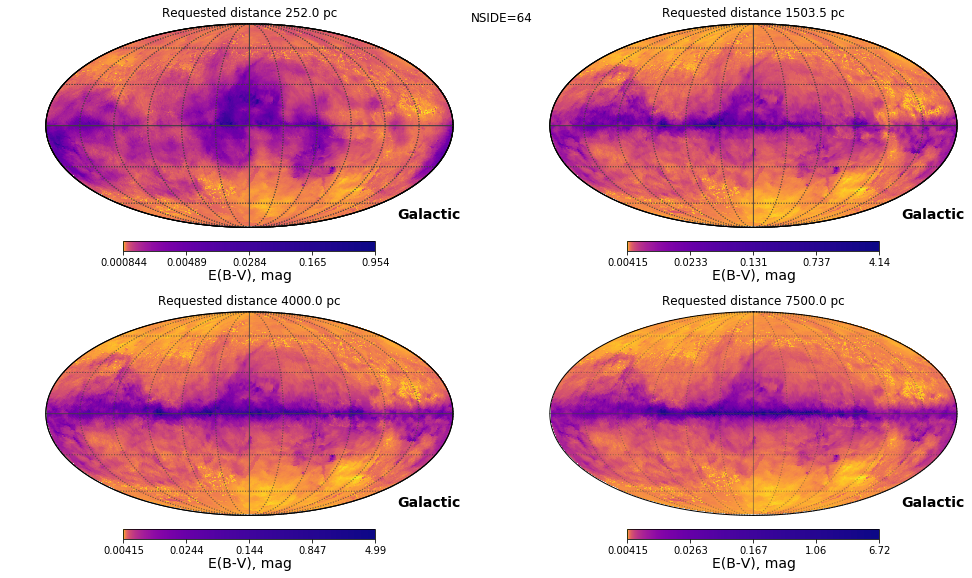

In [14]:
# (if "showExtn" is False, show E(B-V). Otherwise show extinction at supplied filter)
readExtinction.testReadExt(False, pathMap=pathReddening)

#### Another test: show the distance at which (m-M)$_i$ is some fiducial value. ####

(0.5, -1.0)


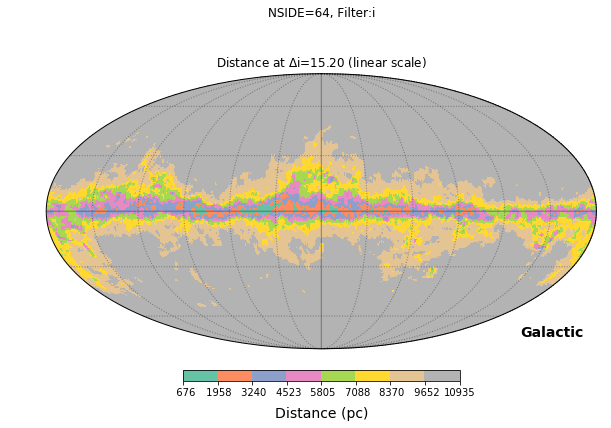

In [15]:
readExtinction.testDeltamags('i', 15.2, cmap='Set2', pathMap=pathReddening)

#### Some routines we need to evaluate the saturation level ####

In [16]:
def selectBrightnessKeys(bg=None, keySat='saturation_mag', keyDepth='CoaddM5'):
    
    """Determine which keys in the bundle dict to use for our 'short' and 'long' exposures"""

    # if a bundle group was not passed in, return dummy keywords that will fail later on.
    if bg is None:
        return 'DUMMY_sat', 'DUMMY_m5'
    
    # Below, we will use the saturation limit and the m5 limiting depth from the 
    # short or long exposures as appropriate. 
    #
    # which keys we use depends on whether there actually *were* "short" as 
    # well as "long" exposures in the opsim. There's probably a sims_maf-ish way 
    # to learn this, but for the moment we just determine which does not have 
    # "None" as the metricValues. We first learn which keys correspond to the 
    # pieces we want, then find out which are populated.

    # These dictionaries are keyed by the search terms in the bundle names.
    # For clarity let's just use one dictionary each for the saturation mag
    # and for the m5 magnitude keys. Doing things this way should allow us 
    # to make changes to the search string up above (e.g. by varying the 
    # filter) and everything from here down should be unaffected.
    keySats = {'lt':'DUMMY', 'gt':'DUMMY'}
    keyMags = {'lt':'DUMMY', 'gt':'DUMMY'}

    # Look for keys that have "lt" and "saturation_mag"
    for sKey in bg.bundleDict.keys():
        for sSz in keySats.keys():
            if sKey.find(sSz) > -1:
                if sKey.find(keySat) > -1:
                    keySats[sSz] = sKey[:]
                if sKey.find(keyDepth) > -1:
                    keyMags[sSz] = sKey[:]

    # Default bundles to use: short exp for saturation and long exp for m5 depth
    keySatUse = keySats['lt'][:]
    keyM5Use = keyMags['gt'][:]

    # If the short-exposure bundle has no metricValues, switch to the long-exposure
    if bg.bundleDict[keySatUse].metricValues is None:
        keySatUse = keySats['gt'][:]

    # if the long-exposure bundle has no metricValues, switch to the short-exposure
    if bg.bundleDict[keyM5Use].metricValues is None:
        keyM5Use = keyMags['lt'][:]
        
    return keySatUse, keyM5Use

In [17]:
def evaluateBundleGroup(pathOpsim='DUMMY', outDir='satur_test', nside=64, timeCut=20., sFilter='r', \
                  doPlots=True, run_name=''):
    
    """Creates and evaluates the bundle group for a particular run"""
    
    ## Refactored from various cells in this notebook
    if not os.access(pathOpsim, os.R_OK):
        return None
    
    # if a run name was not supplied, make one up by parsing the path to the opsim
    if len(run_name) < 1:
        run_name = pathOpsim.split('/')[-1].split('_v')[0]
        
    print("####### INFO - run name:", run_name)
    
    bundleList = []
    
    # declare a few things
    stacker = SaturationStacker()
    metric = metrics.MedianMetric(col='saturation_mag')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [metrics.MedianMetric()]
    plotDict = {}
    plotFuncs = [plots.HealpixSkyMap()]
    resultsDb = db.ResultsDb(outDir=outDir)
    
    # Now we define the bundles for the four types: short+saturation, short+m5, long+saturation, long+m5
    sqlLong = 'filter="%s" and visitExposureTime > %.1f' % (sFilter, timeCut)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlLong,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                stackerList=[stacker]))

    metricM5 = metrics.Coaddm5Metric('fiveSigmaDepth')
    bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlLong,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))

    sqlShort = 'filter="%s" and visitExposureTime < %.1f' % (sFilter, timeCut)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlShort,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                stackerList=[stacker]))

    bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlShort,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))
    
    # actually run things
    conn = db.OpsimDatabase(pathOpsim)
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    
    if doPlots:
        bg.plotAll(closefigs=False)
    
    # returns the bundlegroup
    return bg
    

In [18]:
# let's try a few paths for comparison. These paths are currently hardwired for DATALAB.
lBaseline = glob.glob('/sims_maf/fbs_1.7/baseline/*db')
lShort = glob.glob('/sims_maf/fbs_1.5/short_exp/*db')
lTwilight = glob.glob('/sims_maf/*/twi*_neo/*db')

# 2021-04-08 on Sciserver, the paths are different. Update those here.
if len(lBaseline) < 1:
    dirTop = '/home/idies/workspace/lsst_cadence'
    lBaseline = glob.glob('%s/FBS_1.7/baseline*db' % (dirTop))
    lShort = glob.glob('%s/FBS_1.5/short_exp*db' % (dirTop))
    lTwilight = glob.glob('%s/FBS_1.7/twi*db' % (dirTop))

lPaths = lTwilight + lBaseline + lShort

    
# Note: for the full lpaths above, it takes about an hour to evaluate everything. 
# When developing, probably better to use just the first couple of entries.

## shorten the list for testing the filters
lPaths = [lBaseline[1]] + lShort
lPaths = lPaths[0:2]

print("Paths for opsims:")
lPaths

Paths for opsims:


['/home/idies/workspace/lsst_cadence/FBS_1.7/baseline_nexp1_v1.7_10yrs.db',
 '/home/idies/workspace/lsst_cadence/FBS_1.5/short_exp_5ns_5expt_v1.5_10yrs.db']

### Option 1: Evaluate the saturation level and m5Sigma ###

In [19]:
# Experiment with a loop through opsims
outDir = 'satur_test_2021-04-06'
nside = 64 
timeCut=20.
# sFilter = 'r'
lFilters = ['u', 'g', 'r', 'i', 'z', 'y']
lEvals = []
plotBundles = False 
for pathOpsim in lPaths:
    
    bundlesResults = {}
    for sFilter in lFilters:

        # Create and evaluate the bundle group for this run
        bgroup = evaluateBundleGroup(pathOpsim, outDir, nside, timeCut, sFilter, plotBundles)
    
        # Assess which sets to use for the saturation limit and the m5 depth 
        keySatUse, keyM5Use = selectBrightnessKeys(bgroup)
        
        # pass the appropriate bundles up for computing results
        bundlesResults[sFilter] = {'run_name':bgroup.bundleDict[keySatUse].runName, \
                              'saturation':bgroup.bundleDict[keySatUse], \
                              'm5depth':bgroup.bundleDict[keyM5Use] }
        
    # ok our list of runs should now work OK
    lEvals.append(bundlesResults)

####### INFO - run name: baseline_nexp1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="u" and visitExposureTime < 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:298: UserWarning: No data matching constraint filter="u" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:302: UserWarning:  This means skipping metrics ['Median saturation_mag : u and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : u and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint filter="u" and visitExposureTime > 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']
Found 140409 visits
Running:  ['baseline_nexp1_Median_saturation_mag_u_and_visitExposureTime_gt_20_0_HEAL', 'baseline_nexp1_CoaddM5_u_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: baseline_nexp1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="g" and visitExposureTime < 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:298: UserWarning: No data matching constraint filter="g" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:302: UserWarning:  This means skipping metrics ['Median saturation_mag : g and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : g and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint filter="g" and visitExposureTime > 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']
Found 220748 visits
Running:  ['baseline_nexp1_Median_saturation_mag_g_and_visitExposureTime_gt_20_0_HEAL', 'baseline_nexp1_CoaddM5_g_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: baseline_nexp1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime < 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:298: UserWarning: No data matching constraint filter="r" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:302: UserWarning:  This means skipping metrics ['Median saturation_mag : r and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : r and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint filter="r" and visitExposureTime > 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']
Found 489299 visits
Running:  ['baseline_nexp1_Median_saturation_mag_r_and_visitExposureTime_gt_20_0_HEAL', 'baseline_nexp1_CoaddM5_r_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: baseline_nexp1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="i" and visitExposureTime < 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:298: UserWarning: No data matching constraint filter="i" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:302: UserWarning:  This means skipping metrics ['Median saturation_mag : i and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : i and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint filter="i" and visitExposureTime > 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']
Found 492334 visits
Running:  ['baseline_nexp1_Median_saturation_mag_i_and_visitExposureTime_gt_20_0_HEAL', 'baseline_nexp1_CoaddM5_i_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: baseline_nexp1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="z" and visitExposureTime < 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:298: UserWarning: No data matching constraint filter="z" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:302: UserWarning:  This means skipping metrics ['Median saturation_mag : z and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : z and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint filter="z" and visitExposureTime > 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']
Found 430815 visits
Running:  ['baseline_nexp1_Median_saturation_mag_z_and_visitExposureTime_gt_20_0_HEAL', 'baseline_nexp1_CoaddM5_z_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: baseline_nexp1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="y" and visitExposureTime < 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:298: UserWarning: No data matching constraint filter="y" and visitExposureTime < 20.0
  warnings.warn('No data matching constraint %s' % constraint)
/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:302: UserWarning:  This means skipping metrics ['Median saturation_mag : y and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : y and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


Querying database SummaryAllProps with constraint filter="y" and visitExposureTime > 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']
Found 435014 visits
Running:  ['baseline_nexp1_Median_saturation_mag_y_and_visitExposureTime_gt_20_0_HEAL', 'baseline_nexp1_CoaddM5_y_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
####### INFO - run name: short_exp_5ns_5expt
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="u" and visitExposureTime < 20.0 for columns ['seeingFwhmEff', 'fieldDec', 'visitExposureTime', 'fiveSigmaDepth', 'fieldRA', 'filter', 'skyBrightness', 'airmass', 'numExposures']
Found 91296 visits
Running:  ['short_exp_5ns_5expt_Median_saturation_mag_u_and_visitExposureTime_lt_20_0_HEAL', 'short_exp_5ns_5expt_CoaddM5_u_an

In [20]:
### (Expand the cell above to see lots of screen output.)
## Try viewing the saturation level ##

In [21]:
# let's look at the r-band for the first in the list
satThis = lEvals[0]['r']['saturation'].metricValues
m5sigThis = lEvals[0]['r']['m5depth'].metricValues
nameThis = lEvals[0]['r']['run_name']

print(satThis)
print(m5sigThis)

[-- -- -- ... 14.468040420957697 14.492322570677459 14.352899238321447]
[-- -- -- ... 25.544856209600837 25.370715212871296 25.524318491650217]


In [22]:
### We can compute the distance at which an object of absolute magnitude r would be saturated from this run ###

(0.5, -1.0)


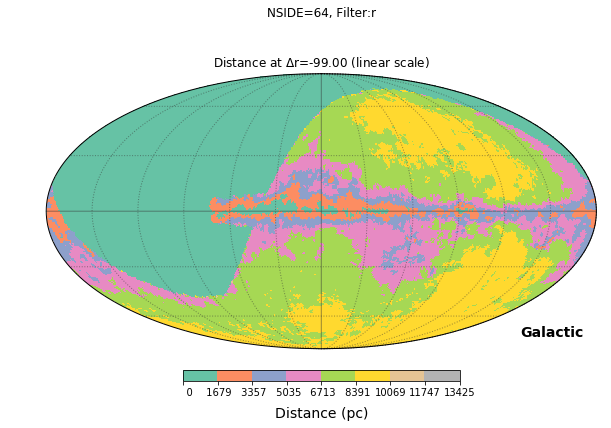

In [23]:
# Let's try absolute magnitude M_r = 0.55 (about right for a clump giant)
M_r = 0.55
mMinusM_sat = satThis - M_r
mMinusM_m5sig = m5sigThis - M_r

# title for figure
suptitl='Distance to median saturation (r) for M_r=%.2f, run %s' % (M_r, nameThis)

# Udpated figure syntax
readExtinction.testDeltamags('r', -99, cmap='Set2', pathMap=pathReddening,  \
                                    dmagVec=mMinusM_sat)

plt.gcf().suptitle=suptitl

# readExtinction.testDeltamags('r', -99, cmap='Set2', pathMap=pathReddening, dmagVec=mMinusM_sat)

# Probably should give testDeltamags the ability to accept strings for the supertitle, etc. In the meantime...
#plt.gcf().suptitle('Distance to median saturation (r) for M_r=%.2f, run %s' % (M_r, nameThis))

(0.5, -1.0)


Text(0.5, 0.98, 'Distance to m5sigma (u) for M_u=2.87, run baseline_nexp1')

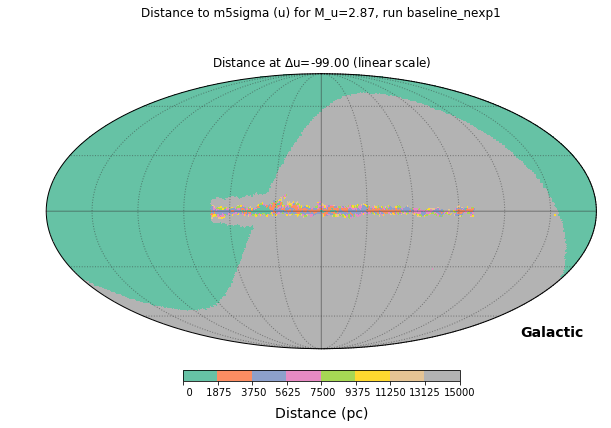

In [24]:
# ... or, what about detections in u-band?
M_u = 2.87
m5sig_u = lEvals[0]['u']['m5depth'].metricValues
mMinusM_m5sig_u = m5sig_u - M_u

readExtinction.testDeltamags('u', -99, cmap='Set2', pathMap=pathReddening, dmagVec=mMinusM_m5sig_u)

# Probably should give testDeltamags the ability to accept strings for the supertitle, etc. In the meantime
# use matplotlib techniques
plt.gcf().suptitle('Distance to m5sigma (u) for M_u=%.2f, run %s' % (M_u, nameThis))

For the 2x15s baseline, Red Clump Giants are fainter than m5sigma throughout much of the mid-plane, though there may be gaps where a large sample out to 5.5kpc might be probed.

### Example 1.1.: looking for the closest distance to saturation out of several filters ###

/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_utils/2.13.0.sims-39-g2d90f6a+7/python/lsst/sims/utils/stellarMags.py:101: FutureWarning: fromrecords expected a list of tuples, may have received a list of lists instead. In the future that will raise an error
  dtype=list(zip(names, types)))


INFO - looking at baseline_nexp1
(0.5, -1.0)
(0.5, -1.0)
(0.5, -1.0)
(0.5, -1.0)


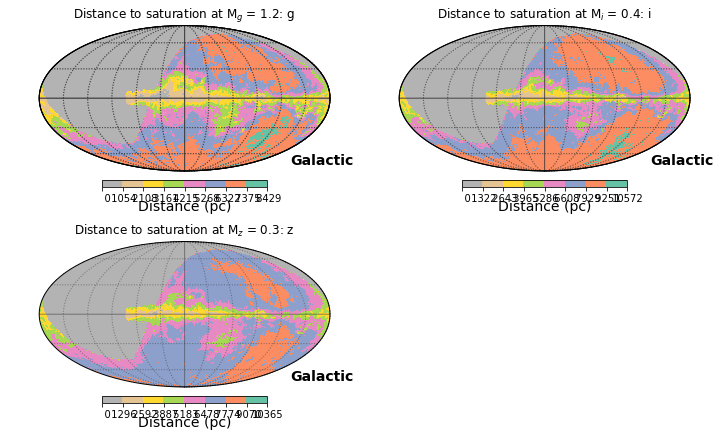

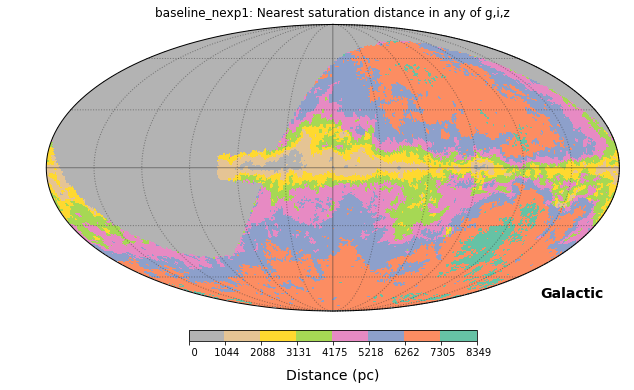

In [25]:
# Here, we loop through a few filters of interest and compare the differences. 
# First we load the extinction map, then we use it.
ebv = readExtinction.ebv3d(pathReddening)
ebv.loadMap()

# we need the absolute magnitudes for our target objects. Let's use a red clump giant:
absMags = sims_utils.stellarMags('K', 0.55)

# In this case we have the saturation level at each filter from upstream in the notebook.
# We take the metric values from the zero'th metric evaluation. For the moment, let's 
# find out the run name:
nameOpsim = lEvals[0]['r']['run_name']
print("INFO - looking at %s" % (nameOpsim))

distsAll = np.array([])
filts = ['g', 'i', 'z']
for iFilter in range(len(filts)):
    thisFilter = filts[iFilter]
    
    # We need the (m-M) for the current filter.
    M_abs = absMags[thisFilter]
    m_this = lEvals[0][thisFilter]['saturation'].metricValues
    mMinusM_sat = m_this - M_abs
    
    # Now we find the distance at which mMinusM_sat is indicated. (Since the "getDistanceAtMag" 
    # routine also returns the mMinusM vector - which in this case we supplied as an input! - 
    # we use "_" to indicate that this second return is a dummy variable.)
    distsClosest, _ = ebv.getDistanceAtMag(mMinusM_sat, thisFilter)
    
    # stack this on to the master array that indicates distances for each filter
    if np.size(distsAll) < 1:
        distsAll = np.copy(distsClosest)
    else:
        distsAll = np.vstack(( distsAll, distsClosest))
    
    # Plot the result (the fontsize for the colorbars needs updating!)
    sTitle = r'Distance to saturation at M$_%s$ = %.1f: %s' % (thisFilter, M_abs, thisFilter)
    thisFigure = ebv.showMollview(distsClosest, 1, cmap='Set2_r', norm='linear', \
                                   coord=['C','G'], sUnit='Distance (pc)', \
                                 subplot=(2,2,iFilter+1), clobberFigure=iFilter < 1, \
                                 sTitle=sTitle, \
                                 margins=(0.02, 0.04, 0.00, 0.01))

# Now find the minimum distance at each sightline.
distLims = np.min(distsAll, axis=0)
    
# Plot this minimum distance
sSuptitle = '%s: Nearest saturation distance in any of %s' % (nameOpsim, ','.join(filts))
fig2 = ebv.showMollview(distLims, 2, cmap='Set2_r', norm='linear', \
                                   coord=['C','G'], sUnit='Distance (pc)', \
                                 clobberFigure=True, \
                                 sTitle=sSuptitle)

fig2.savefig('test_closestDistance.png')

### Option 2: load saturation map from a previous run (if present at the specified path) ###

In [26]:
# use sims_maf to predict the apparent magnitudes for a red clump giant.
#
# The r-band absolute magnitude of about 0.55 is taken from Ruiz-Dern et al. 
# 2018, here: https://www.aanda.org/articles/aa/full_html/2018/01/aa31572-17/aa31572-17.html
absMags = sims_utils.stellarMags('K', 0.55)
print(absMags)

{'r': 0.55, 'i': 0.3703089144, 'z': 0.30538612754000005, 'y': 0.26287054484000005, 'g': 1.1581567546, 'u': 2.8747917785999997}


In [27]:
# which filter do we use throughout
sFilter = 'z'

In [28]:
# load the map for the filter we chose. Here we're using the 1x30s baseline as an example.
pathmap = './satur_test/baseline_nexp1_Median_saturation_mag_%s_and_visitExposureTime_gt_20_0_HEAL.npz' % (sFilter)
with np.load(pathmap) as oldData:
    valu = oldData['metricValues']
    mask = np.asarray(oldData['mask'], dtype='bool')
    thisMetric = np.ma.masked_array(valu, mask=mask)

FileNotFoundError: [Errno 2] No such file or directory: './satur_test/baseline_nexp1_Median_saturation_mag_z_and_visitExposureTime_gt_20_0_HEAL.npz'

In [ ]:
# hp.mollview doesn't seem to understand what to do with masked values when imported 
# in this manner, showing them as values of 1e20 rather than the canonical badval.
thisShow = np.ma.copy(thisMetric)
thisShow.soften_mask()
thisShow[thisShow.mask] = np.ma.min(thisShow)
thisShow.mask[~np.isfinite(thisShow)] = True
hp.mollview(thisShow)

In [ ]:
### For a given absolute magnitude, work out the delta magnitude between
### the apparent magnitudes above and the absolute magnitude
mAbs = absMags[sFilter] # about right for a red clump giant
obsMinusAbs = thisMetric - mAbs

print("Absolute magnitude at %s is %.2f" % (sFilter, mAbs))

# Now feed this as delta magnitudes to our reddening methods

readExtinction.testDeltamags(sFilter, -99, cmap='Set2', pathMap=pathReddening, dmagVec=obsMinusAbs)

blah = plt.gcf().suptitle('Distance in kpc to saturation, M=%.1f in %s; path %s' \
                   % (mAbs, sFilter, os.path.split(pathmap)[-1]))

plt.gcf().savefig('test_dist2saturation_30s_%s_RCG.png' % (sFilter))

So, for the 1x30s baseline survey, Red Clump Giants appear to saturate any closer than about 5-6kpc moderately close to the midplane, and at about 7-8kpc over most of the rest of the sky - in z-band.